# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, we analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR', low_memory=True) # Demographics data for the general population of Germany

C:\Users\max.000\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';', index_col='LNR', low_memory=True) # Demographics data for customers
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [4]:
print(f'azdias    number of columns: {azdias.shape[1]}')
print(f'customers number of columns: {customers.shape[1]}')

azdias    number of columns: 365
customers number of columns: 365


#### Preprocess Function

In [3]:
# drop unknown (non-described) columns
def drop_nondescr_columns(df):
    
    columns_to_drop = ['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_STATISTISCHE_HAUSHALTE', 
                       'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 
                       'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 
                       'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 
                       'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 
                       'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 
                       'VK_DISTANZ', 'VK_ZG11'] #LNR
    df.drop(columns=columns_to_drop, inplace=True)
    
    return df

In [4]:
# rename columns
def rename_columns(df):
    
    column_new_names = {'CAMEO_INTL_2015': 'CAMEO_DEUINTL_2015', 'D19_BANKEN_DIREKT': 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS': 'D19_BANKEN_GROSS_RZ', 
                        'D19_BANKEN_LOKAL': 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST': 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH': 'D19_BEKLEIDUNG_GEH_RZ', 
                        'D19_BEKLEIDUNG_REST': 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG': 'D19_BILDUNG_RZ', 'D19_BIO_OEKO': 'D19_BIO_OEKO_RZ', 
                        'D19_BUCH_CD': 'D19_BUCH_RZ', 'D19_DIGIT_SERV': 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL': 'D19_DROGERIEARTIKEL_RZ', 
                        'D19_ENERGIE': 'D19_ENERGIE_RZ', 'D19_FREIZEIT': 'D19_FREIZEIT_RZ', 'D19_GARTEN': 'D19_GARTEN_RZ', 'D19_HANDWERK': 'D19_HANDWERK_RZ', 
                        'D19_HAUS_DEKO': 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL': 'D19_KINDERARTIKEL_RZ', 'D19_KOSMETIK': 'D19_KOSMETIK_RZ', 
                        'D19_LEBENSMITTEL': 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO': 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG': 'D19_NAHRUNGSERGAENZUNG_RZ', 
                        'D19_RATGEBER': 'D19_RATGEBER_RZ', 'D19_REISEN': 'D19_REISEN_RZ', 'D19_SAMMELARTIKEL': 'D19_SAMMELARTIKEL_RZ', 
                        'D19_SCHUHE': 'D19_SCHUHE_RZ', 'D19_SONSTIGE': 'D19_SONSTIGE_RZ', 'D19_TECHNIK': 'D19_TECHNIK_RZ', 
                        'D19_TELKO_MOBILE': 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST': 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL': 'D19_TIERARTIKEL_RZ', 
                        'D19_VERSAND_REST': 'D19_VERSAND_REST_RZ', 'D19_VERSICHERUNGEN': 'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT': 'D19_VOLLSORTIMENT_RZ', 
                        'D19_WEIN_FEINKOST': 'D19_WEIN_FEINKOST_RZ', 'KK_KUNDENTYP': 'D19_KK_KUNDENTYP', 'SOHO_KZ' : 'SOHO_FLAG'}
    
    df.rename(columns=column_new_names, inplace=True)
    
    return df

In [5]:
# fix wrong inputs
def fix_wrong_input(df):
    
    # The following values (X and XX) are not described at the attribute description list in specific columns(attributes).
    wrong_inputs = {'CAMEO_DEUG_2015': 'X',
                    'CAMEO_DEU_2015': 'XX',
                    'CAMEO_DEUINTL_2015': 'XX'}
    df.replace(to_replace=wrong_inputs, value=np.nan, inplace=True)
    
    # The following two columns can be set to type float since now they contain only numbers
    for col in ['CAMEO_DEUG_2015', 'CAMEO_DEUINTL_2015']:
        df[col] = df[col].astype(float)
    
    return df

In [6]:
# a top-level list of attributes and descriptions, organized by informational category
attr_values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header = 1)

# Processing Attributes-Values dataset

# drop first empty column and description column
attr_values.drop(columns=['Unnamed: 0', 'Description'], inplace=True)

# Fill missing values in Attribute column by propagating last valid observation forward
attr_values['Attribute'].ffill(inplace=True)

# convert all Value values to string, so to have a uniform datatype for easier processing later
attr_values['Value'] = attr_values['Value'].astype(str)

In [7]:
# uknown/wrong values to nan
def unknown_to_nan(df):
    
    unknown_values_list = ['unknown', 
                            'no transaction known', 
                            'no transactions known', 
                            'unknown / no main age detectable']

    # Create a dataframe only with values that mean unknown/missing values in each column
    unknown_attrs = attr_values[attr_values['Meaning'].isin(unknown_values_list)].copy().reset_index(drop = True)

    # Create a dictionary of values to be replaced with NaN values in each column
    missing_or_unknown = {}
    for (idx, row) in unknown_attrs.iterrows():
        attr = row['Attribute']
        values = row['Value'].split(',')
        missing_or_unknown[attr] = []
        for val in values:
            val = int(val)
            missing_or_unknown[attr].append(val)

    df.replace(to_replace=missing_or_unknown, value=np.nan, inplace=True)
    
    return df

In [8]:
def split_mix_columns(df):
    # Engineer Mixed-Type Features
    
    # split CAMEO_DEUINTL_2015 into two columns (wealth and life-stage)
    df['CAMEO_DEUINTL_2015_wealth'] = df['CAMEO_DEUINTL_2015'].map(lambda x: int(str(x)[0]) , na_action='ignore')
    df['CAMEO_DEUINTL_2015_lifestage'] = df['CAMEO_DEUINTL_2015'].map(lambda x: int(str(x)[1]) , na_action='ignore')
    
    df.drop(columns=['CAMEO_DEUINTL_2015'], inplace=True)
    
    # split PRAEGENDE_JUGENDJAHRE into two columns (generation decade and movement)
    decade_map = {1:1, 2:1, # 1: 40s
                  3:2, 4:2, # 2: 50s
                  5:3, 6:3, 7:3, # 3: 60s
                  8:4, 9:4, # 4: 70s
                  10:5, 11:5, 12:5, 13:5, #5: 80s
                  14:6, 15:6} # 6: 90s
    
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    
    # movement mapping  1: mainstream 2: avantgarde
    def set_movement(x):
        if x in [1,3,5,8,10,12,14]:
            return 1
        elif x in [2,4,6,7,9,11,13,15]:
            return 2
        
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(set_movement)
    
    df.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    
    return df

In [9]:
# drop columns that miss more than 30% of values

NAN_COLS_TO_DROP = [] # global variable

def drop_cols_nan_thres(df):
    # drop columns with high percentage of missing values
    
    def cols_nan_thres(df, threshold):
        col_nan_pc = df.isnull().mean()*100
        cols_above_thres = col_nan_pc[col_nan_pc > threshold].index.to_list()
        return cols_above_thres
    
    global NAN_COLS_TO_DROP
    
    if not(NAN_COLS_TO_DROP):
        NAN_COLS_TO_DROP = cols_nan_thres(azdias, 70)
    
    df.drop(columns=NAN_COLS_TO_DROP, inplace=True)
    
    return df

In [10]:
def encode_cols(df):
    
    # we let columns with numerical binary values (0-1) as is
    
    # encoding binary non-numerical feature
    df.replace( {'OST_WEST_KZ': {'W':0, 'O':1}}, inplace=True )
    # standardize numberical binary to 0-1
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    # discard features high cardinality features
    cols_to_drop = ['CAMEO_DEU_2015', 'GEBAEUDETYP']
    df.drop(columns=cols_to_drop, inplace=True)
    
    # Encode categorical columns
    cat_cols_to_encode = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                        'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015']
    
    encoded_df = pd.get_dummies(df, columns = cat_cols_to_encode)
    
    
    return encoded_df

In [11]:
def clean_data(df):
    
    df = drop_nondescr_columns(df) # drop unknown columns
    df = rename_columns(df) # rename columns
    df = fix_wrong_input(df) # replace X values with NaN and fix dtypes in specific columns
    df = unknown_to_nan(df) # replace values that mean unknown with NaN
    df = split_mix_columns(df) # engineer Mixed-Type Features
    df = drop_cols_nan_thres(df) # drop columns with high percentage of missing values
    df = encode_cols(df) # encode categorical columns
    
    return df 

In [14]:
azdias = clean_data(azdias)

In [15]:
customers = clean_data(customers)

In [ ]:
#Imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [17]:
# Scaling
scaler = StandardScaler()

azdias = pd.DataFrame(scaler.fit_transform(azdias.astype(float)), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers.astype(float)), columns = customers.columns)

In [18]:
print(f'azdias    number of columns: {azdias.shape[1]}')
print(f'customers number of columns: {customers.shape[1]}')

azdias    number of columns: 336
customers number of columns: 336


#### Convert categorical features to a numerical representation.

An ordinal feature is best described as a feature with natural, ordered categories and the distances between the categories is not known.

one-hot-encoding. Essentially, each categorical feature with n categories is transformed into n binary features.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Dimensionality Reduction
##### Principal Component Analysis (PCA)

In [20]:
from sklearn.decomposition import PCA
pca = PCA()

In [21]:
azdias_pca=pca.fit_transform(azdias)

In [22]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    INPUT: pca - the result of instantian of PCA in scikit learn
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(11, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:3])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title("Explained Variance Per Principal Component")

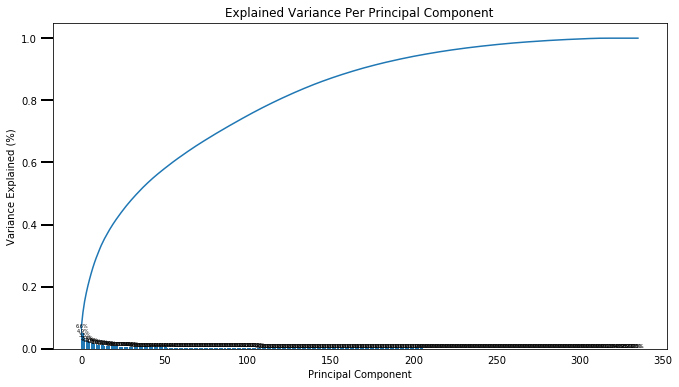

In [23]:
scree_plot(pca)

Based on the scree plot I believe that 100 features explain pretty well the variance and there's no benefit using more. That's a significant decrease from the initial number of features.

In [24]:
pca_100 = PCA(n_components = 100)
azdias_pca_100 = pca_100.fit_transform(azdias)

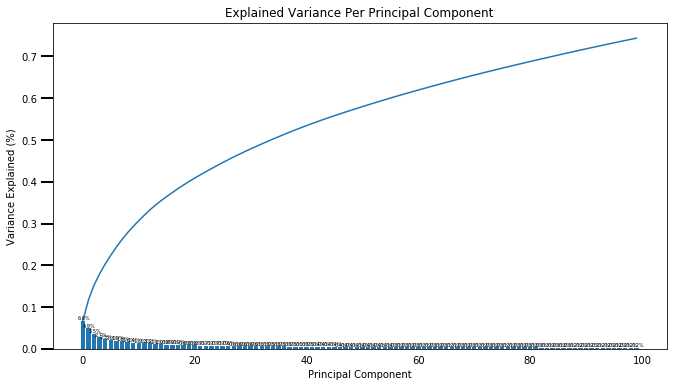

In [25]:
scree_plot(pca_100)

In [ ]:
np.sum(pca.explained_variance_ratio_[:100])

Conclusion:
100 features can explain 81% of the variability in the dataset!

### PCA Interpretation

In [27]:
vals = pca.explained_variance_ratio_

In [28]:
def pca_weights(pca,i):
    
    print('{:5.2%}'.format(vals[i]))
    components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias.keys())
    weights = components.iloc[i].sort_values()
    
    return weights

In [29]:
# first pricinipal component
pca_weights_100_0 = pca_weights(pca_100, 0)
print(pca_weights_100_0)

6.69%
MOBI_REGIO                  -0.1571
PLZ8_ANTG1                  -0.1498
KBA05_ANTG1                 -0.1472
KBA05_GBZ                   -0.1401
KBA05_AUTOQUOT              -0.1374
                              ...  
PLZ8_BAUMAX                  0.1353
LP_STATUS_GROB_1.0           0.1398
PLZ8_ANTG4                   0.1401
PLZ8_ANTG3                   0.1448
CAMEO_DEUINTL_2015_wealth    0.1502
Name: 0, Length: 336, dtype: float64


Lowest:  
KBA05_ANTG1 number of 1-2 family houses in the cell  
FINANZ_MINIMALIST financial typology: low financial interest  
KBA05_GBZ number of buildings in the microcell  
MOBI_REGIO moving patterns  
PRAEGENDE_JUGENDJAHRE_MOVEMENT movement avantagarde/mainstream  
Highest:  
PLZ8_BAUMAX most common building-type within the PLZ8  
LP_STATUS_FEIN_1.0   social status fine - typical low-income earners  
PLZ8_ANTG4 number of >10 family houses in the PLZ8  
CAMEO_DEUINTL_2015_wealth household wealth  
LP_STATUS_GROB_1.0 social status rough - low-income earners



In [30]:
# second pricinipal component
pca_weights_100_1 = pca_weights(pca_100, 1)
print(pca_weights_100_1)

4.97%
KBA13_SITZE_5                 -0.1441
KBA13_ALTERHALTER_60          -0.1313
KBA13_KMH_140_210             -0.1298
KBA13_HALTER_20               -0.1294
KBA13_SEG_KLEINWAGEN          -0.1253
                                ...  
KBA13_SITZE_4                  0.1465
KBA13_MERCEDES                 0.1530
KBA13_BMW                      0.1531
KBA13_SEG_OBEREMITTELKLASSE    0.1576
KBA13_HERST_BMW_BENZ           0.1814
Name: 1, Length: 336, dtype: float64


Lowest:  
FINANZ_ANLEGER  financial typology: investor  
FINANZ_SPARER   financial typology: money saver  
FINANZ_UNAUFFAELLIGER  financial typology: unremarkable  
SEMIO_REL  affinity indicating in what way the person is religious  
PRAEGENDE_JUGENDJAHRE_DECADE  decade of youth movement  
Highest:  
LP_FAMILIE_FEIN_1.0   familytyp fine - single   
SEMIO_LUST   affinity indicating in what way the person is sensual minded  
RETOURTYP_BK_S     shopping return type  
FINANZ_VORSORGER  financial typology: be prepared  
ZABEOTYP typification of energy consumers - fair supplied  

In [31]:
# third pricinipal component
pca_weights_100_2 = pca_weights(pca_100, 2)
print(pca_weights_100_2)

3.57%
FINANZ_VORSORGER               -0.2079
ALTERSKATEGORIE_GROB           -0.2034
SEMIO_ERL                      -0.1552
ZABEOTYP_3                     -0.1548
SEMIO_LUST                     -0.1473
                                 ...  
FINANZ_ANLEGER                  0.1939
SEMIO_PFLICHT                   0.2014
FINANZ_UNAUFFAELLIGER           0.2015
PRAEGENDE_JUGENDJAHRE_DECADE    0.2287
FINANZ_SPARER                   0.2332
Name: 2, Length: 336, dtype: float64


Lowest:  
FINANZTYP_6 best descirbing financial type for the person - unremarkable  
OST_WEST_KZ   flag indicating the former GDR/FRG  
KBA13_SITZE_5  number of cars with 5 seats in the PLZ8  
LP_STATUS_GROB_4.0      social status rough - average earners  
LP_STATUS_FEIN_9.0      social status fine - houseowners  
Highest:  
KBA13_SITZE_4      number of cars with less than 5 seats in the PLZ8  
KBA13_CCM_3001     share of cars with more than 3000ccm within the PLZ8  
KBA13_SEG_SPORTWAGEN    share of sportscars within the PLZ8  
KBA13_HERST_BMW_BENZ     share of BMW & Mercedes Benz within the PLZ8  
FINANZ_UNAUFFAELLIGER    financial typology: unremarkable  

#### Conclusions:

The first principal component is related to social status, wealth, area building density.  
The second principal component is related to family type, financial type, consumer type, personality type.  
The third principal component is related to lux/sport cards, financial yype, social status.  

### K-Means Clustering

In [34]:
from sklearn.cluster import KMeans

scores = []
K = range(1, 13,2)
for k in K:
    print(f'calculating scores for {k} cluster(s)')
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(azdias_pca_100)
    scores.append(np.abs(kmeanModel.score(azdias_pca_100)))

calculating scores for 1 cluster(s)
calculating scores for 3 cluster(s)
calculating scores for 5 cluster(s)
calculating scores for 7 cluster(s)
calculating scores for 9 cluster(s)
calculating scores for 11 cluster(s)


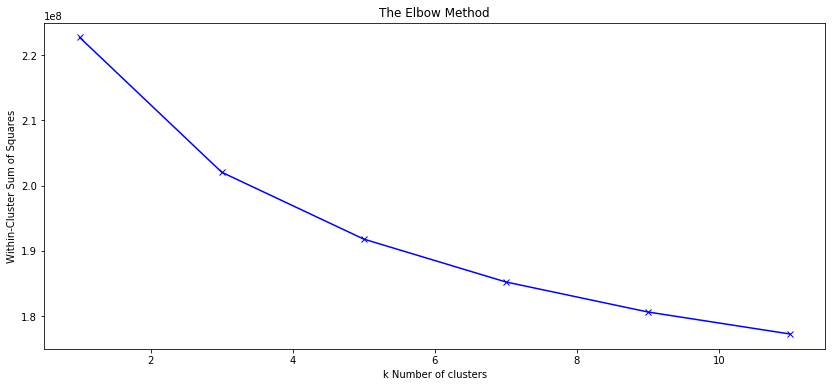

In [35]:
plt.figure(figsize=(14,6))
plt.plot(K, scores, '-bx')
plt.xlabel('k Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('The Elbow Method')
plt.show()

In [37]:
# Re-fit the k-means model with the 9 clusters
kmeansModel9 = KMeans(n_clusters = 9)
model9 = kmeansModel9.fit(azdias_pca_100)

# Cluster prediction for the general population (predicts the closest cluster each sample in azdias_pca_100 belongs to)
population_clusters = kmeansModel9.predict(azdias_pca_100)

### Clustering customer data

In [38]:
#transform the customers data using pca object
customers_pca = pca_100.transform(customers)

#predict clustering using the kmeans object
customers_clusters = model9.predict(customers_pca)

### Compare customer data to demographic data

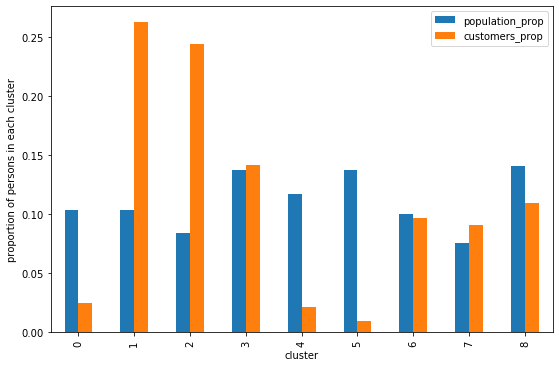

In [45]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_prop = []
customers_prop = []

for i in range(9):
    population_prop.append((population_clusters == i).sum()/len(population_clusters))
    customers_prop.append((customers_clusters == i).sum()/len(customers_clusters))

comparison_data = pd.DataFrame({'cluster' : range(9), 'population_prop' : population_prop, 'customers_prop': customers_prop})

comparison_data.plot(x = 'cluster', y = ['population_prop', 'customers_prop'], kind = 'bar', figsize = (9,6))

plt.ylabel('proportion of persons in each cluster')

plt.show()

#### Clusters overrepresenting Customer Data
Clusters 1 and 2 have much higher proportion of persons in the company's customers dataset than the general population one, so they are good target audience for the company. 

In [51]:
centroid_1 = pca_100.inverse_transform(model9.cluster_centers_[1])
pd.Series(data = centroid_1, index = customers.columns).sort_values()

HH_EINKOMMEN_SCORE               -1.136499
CAMEO_DEUINTL_2015_wealth        -0.975951
LP_STATUS_GROB_1.0               -0.736889
FINANZ_ANLEGER                   -0.728248
FINANZ_SPARER                    -0.715459
                                    ...   
KBA05_ANTG1                       1.071257
GREEN_AVANTGARDE                  1.832444
PRAEGENDE_JUGENDJAHRE_MOVEMENT    1.832444
LP_STATUS_GROB_5.0                1.990572
LP_STATUS_FEIN_10.0               1.990572
Length: 336, dtype: float64

Average to top earners, german nationality, green avantgarde

In [49]:
centroid_2 = pca_100.inverse_transform(model9.cluster_centers_[2])
pd.Series(data = centroid_2, index = customers.columns).sort_values()

NATIONALITAET_KZ_1.0   -1.749101
SEMIO_VERT             -1.376680
HH_EINKOMMEN_SCORE     -1.219753
GEBURTSJAHR            -1.189768
SEMIO_SOZ              -0.981493
                          ...   
GFK_URLAUBERTYP_5.0     1.522356
LP_FAMILIE_FEIN_0.0     1.947398
LP_FAMILIE_GROB_0.0     1.947398
LP_STATUS_FEIN_5.0      2.037368
FINANZTYP_4             2.355359
Length: 336, dtype: float64

 "be prepared" financial type,  minimalistic high-income earners  

#### Clusters underrepresenting Customer Data
Clusters 4 and 5  have much higher proportion of persons in the general population dataset than the company's customers one, so they should be avoided for marketing campaigns.

In [52]:
centroid_4 = pca_100.inverse_transform(model9.cluster_centers_[4])
pd.Series(data = centroid_4, index = customers.columns).sort_values().tail(10)

CAMEO_DEUG_2015_9.0     1.089668
KBA13_HALTER_40         1.106165
KBA13_HALTER_30         1.131626
KBA13_ALTERHALTER_45    1.156153
EWDICHTE                1.165332
ORTSGR_KLS9             1.173576
PLZ8_ANTG3              1.180202
PLZ8_ANTG4              1.296178
KBA13_HALTER_35         1.345664
PLZ8_BAUMAX             1.479695
dtype: float64

upper class in low density areas

In [53]:
centroid_5 = pca_100.inverse_transform(model9.cluster_centers_[5])
pd.Series(data = centroid_5, index = customers.columns).sort_values().tail(10)

SEMIO_REL                       0.700457
LP_STATUS_FEIN_2.0              0.758435
FINANZ_ANLEGER                  0.787718
SEMIO_RAT                       0.803243
FINANZ_UNAUFFAELLIGER           0.846282
SEMIO_PFLICHT                   0.865434
SEMIO_TRADV                     0.887956
PRAEGENDE_JUGENDJAHRE_DECADE    0.983183
FINANZ_SPARER                   1.031040
FINANZTYP_1                     1.041753
dtype: float64

low income, low money-saving, poor household, in dense areas 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Preparing data

In [12]:
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';', index_col='LNR', low_memory = False)

In [13]:
print(f'mailout_train number of features: {mailout_train.shape[1]}')

mailout_train number of features: 366


In [14]:
print(f'Positive percentage = { (mailout_train.RESPONSE == 1).mean() * 100 :.2f}%')
print(f'Total # of positive pts: { (mailout_train.RESPONSE == 1).sum() }')
print(f'Out of (total) pts: { mailout_train.shape[0]}' )

Positive percentage = 1.24%
Total # of positive pts: 532
Out of (total) pts: 42962


Only 1.24% of people has reponded to the campaign.
The data is highly imbalanced.

In [15]:
X = mailout_train.drop(columns='RESPONSE')

y = mailout_train['RESPONSE']

In [16]:
print(f'X number of features: {X.shape[1]}')

X number of features: 365


In [17]:
X = clean_data(X)

In [18]:
print(f'X number of features: {X.shape[1]}')

X number of features: 383


In [19]:
#Imputation
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.astype(float)), columns = X.columns)

### Comparing models and algorithms

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [76]:
clf_1 = LogisticRegression(random_state=10)
clf_2 = RandomForestClassifier(random_state=10)
clf_3 = AdaBoostClassifier(random_state=10)
clf_4 = GradientBoostingClassifier(random_state=10)

In [42]:
def classifier_score(clf, param_grid={}):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='roc_auc', 
                        verbose = 1, 
                        n_jobs=8,
                        cv=5) # StratifiedKFold
    grid.fit(X, y)

    print(grid.best_score_)
    
    return grid.best_estimator_

In [78]:
for clf in [clf_1, clf_2, clf_3, clf_4]:
    print(classifier_score(clf))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.6s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    7.8s finished
C:\Users\max.000\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


0.598197799248468
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   18.4s remaining:   27.6s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   19.3s finished


0.5149242003581324
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   22.4s remaining:   33.7s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   22.7s finished


0.5833553230058965
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=10)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.3min finished


0.6021045377965046
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Optimize/Tune model

In [23]:
param_grid = {'learning_rate': [0.05, 0.01], 
              'n_estimators': [100, 250]}

grid = GridSearchCV(estimator=GradientBoostingClassifier(max_depth=4, random_state=10, verbose=1), param_grid=param_grid, scoring='roc_auc', 
                    verbose=3, n_jobs=8, cv=5)

grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:  7.5min remaining:  5.0min
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed: 12.0min finished


      Iter       Train Loss   Remaining Time 
         1           0.1331            1.77m
         2           0.1330            1.65m
         3           0.1328            1.59m
         4           0.1327            1.54m
         5           0.1326            1.56m
         6           0.1325            1.59m
         7           0.1324            1.62m
         8           0.1323            1.61m
         9           0.1322            1.59m
        10           0.1321            1.57m
        20           0.1313            1.50m
        30           0.1306            1.27m
        40           0.1300            1.06m
        50           0.1294           52.16s
        60           0.1288           41.12s
        70           0.1282           30.64s
        80           0.1277           20.71s
        90           0.1272           10.63s
       100           0.1268            0.00s
0.6228839804317612
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
 

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [31]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=';', index_col='LNR', low_memory = False)
print(f'mailout_test number of features: {X_test.shape[1]}')

mailout_test number of features: 383


In [32]:
lnr = mailout_test.index

In [33]:
X_test = clean_data(mailout_test)
print(f'mailout_test number of features: {X_test.shape[1]}')

mailout_test number of features: 383


In [34]:
#Imputation
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)

In [35]:
# Scaling
X_test = pd.DataFrame(scaler.fit_transform(X_test.astype(float)), columns = X_test.columns)

In [36]:
# Predict the response for test dataset (y_predict)
# use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = grid.predict_proba(X_test)

Output for Kaggle

In [37]:
# generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,0]})
result.to_csv(path_or_buf='./result.csv', index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.985129
1,1770,0.980601
2,1465,0.993860
3,1470,0.992772
4,1478,0.988769
5,1782,0.993860
6,1485,0.985240
7,1519,0.988409
8,1835,0.987993
9,1522,0.984648
